# Quantitative Trading Strategy
#### By: Ruby Han

## Abstract
Forecasting market movement is a long-time attractive topic. This project aims to evaluate different algorithmic strategies on Apple, Microsoft, ExxonMobil, Chevron, Tesla using S&P 500 index as the benchmark over a one-year period (2021). An agent framework was built to trigger buy or sell orders with an initial capital of $10,000 based on selected strategy. Return on investment (ROI) was used as the performance metric. Base model outperformed other strategies with ROI of 31.5\% but deep reinforcement learning model Evolution Strategy coming close in second place. Success of each strategy varied wildly with each stock for the time period. Machine learning models fared better than technical indicator models.

## Problem Objective 
- Create a quantitative trading strategy for any stocks
- No restriction on number of times entering or exiting the market, or long/short for period of strategy
- Benchmark with S&P 500 index
- Elucidate results and conclusion
- Provide future work and considerations given more time and resources

## Models Built

**Base Model:**

- Buy and Hold: Invest initial capital on first day and hold until last trading day

**Technical Indicators:**

- Bollinger Bands: Momentum model using moving standard deviations as bands

- MACD: Moving average convergence divergence index

**Machine Learning Models**

- Evolution Strategy: Deep reinforcement learning model

- LSTM: Long short-term memory model


## Result Summary

**Performance Metrix:**

$$\text{Return on Investment (ROI)}=\frac{\text{Current Value of Investment}-\text{Investment Cost}}{\text{Investment Cost}}$$

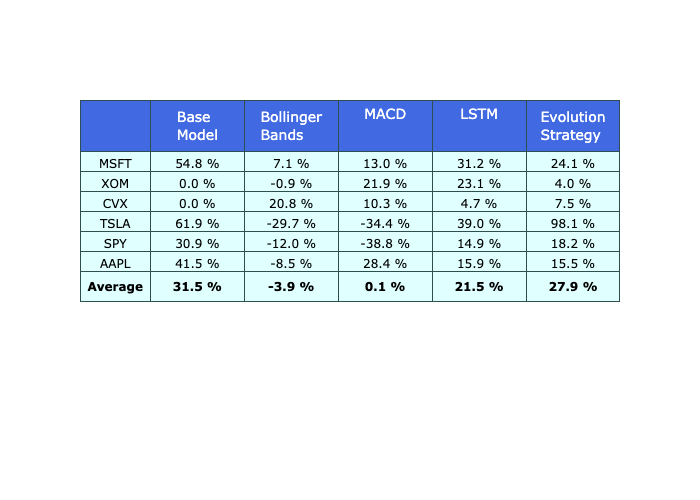

In [32]:
from IPython.display import Image, Markdown as md
Image('images/result_table.png')

## Navigation <a id = 0> </a>
- [Data Load](#1)
- [EDA](#2)
- [Feature Engineering](#3)
    - [MACD](#3.1)
    - [Bollinger](#3.2)
    - [RSI](#3.3)
    - [Normal Distribution](#3.4)
- [Model](#4)
    - [Base Model](#4.0)
    - [Bollinger Bands](#4.1)
    - [MACD](#4.2)
    - [LSTM](#4.3)
    - [Evolution Strategy](#4.4)
- [Result](#5)
- [Conclusion](#6)
- [Future Work](#7)
- [References](#8)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import compress

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import yfinance as yf
import pandas_datareader as pdr

from feature_eng import MACD, bollinger_bands, RSI, momentum

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import backtrader as bt

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

## Data Load <a id = 1> </a> 
[Back to Top](#0)

- ^GSPC : S&P 500 index data
- XOM : ExxonMobil
- CVX : Chevron
- AAPL : Apple
- TSLA : Tesla
- MSFT : Microsoft
- SPY : S&P 500 ETF

##### Terminology
- `Open` : Stock price at market open (USD)
- `High` : Highest price reached per day (USD)
- `Low` : Lowest price reached per day (USD)
- `Close` : Stock price at market close (USD)
- `Adj Close` : Adjusted stock price at market close (USD)
- `Volume` : Number of shares traded per day

In [3]:
# Obtain stock data from Yahoo Finance
start = '2021-01-04'
end = '2022-01-04'

tickers = [
    '^GSPC' # sp500 index
    ,'XOM' # exxon
    ,'CVX' # chevron
    ,'AAPL' # apple
    ,'TSLA' # tesla
    ,'MSFT' # microsoft
    ,'SPY' # sp500 ETF
          ]

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker, '2000')
    data.to_csv(f'data/raw_stocks/{ticker}.csv')

# data = yf.download('AAPL', start=start, end=end)

## EDA <a id = 2> </a> 
[Back to Top](#0)

In [4]:
apple_raw_df = pd.read_csv('data/raw_stocks/AAPL.csv')
apple_raw_df.head()

Date      High       Low      Open     Close       Volume  Adj Close
0  2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855796
1  2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644
2  2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111
3  2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304
4  2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708

In [5]:
apple_raw_df.shape

(5576, 7)

In [6]:
apple_raw_df.describe()

High          Low         Open        Close        Volume  \
count  5576.000000  5576.000000  5576.000000  5576.000000  5.576000e+03   
mean     25.597790    25.055282    25.326246    25.337188  4.267585e+08   
std      37.047319    36.222712    36.630190    36.653385  3.889380e+08   
min       0.235536     0.227143     0.231964     0.234286  3.934000e+07   
25%       1.576518     1.534911     1.560714     1.561786  1.556468e+08   
50%      11.966607    11.766428    11.865000    11.861250  3.107328e+08   
75%      30.956875    30.412499    30.660000    30.642500  5.666332e+08   
max     182.940002   179.119995   182.630005   182.009995  7.421641e+09   

         Adj Close  
count  5576.000000  
mean     24.230080  
std      36.544004  
min       0.200613  
25%       1.337317  
50%      10.156480  
75%      28.196388  
max     181.778397

In [7]:
apple_raw_df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [8]:
# Check for null values
# If exist, use last good value, mean, zero or drop observation
apple_raw_df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## Feature Engineering <a id = 3> </a> 
[Back to Top](#0)

- Indicators are tools that help traders/investors make buying/selling stocks decisions
- Technical indicators (features in our case):
    - Price
    - Volume
- The following features will be created:
    - Bollinger Bands
    - RSI
    - MACD
    - Moving Average
    - Momentum
    - Change
    - Volatility
    - Return
- Target variable: `Return`
- All other features will serve as predictors

In [9]:
!rm -rf data/raw_stocks/.ipynb_checkpoints
files = os.listdir('data/raw_stocks')
stocks = {}

for file in files:
    name = file.split('.')[0]
    stocks[name] = pd.read_csv(f'data/raw_stocks/{file}') 
    
    stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date'])
    stocks[name].set_index('Date', inplace=True)
    
    # Bollinger Bands
    stocks[name]['upper_boll_band'], stocks[name]['lower_boll_band'] = bollinger_bands(stocks[name])
    
    # MACD
    stocks[name]['macd'], stocks[name]['signal'] = MACD(stocks[name])
    
    # RSI
    stocks[name]['rsi'] = RSI(stocks[name])
    
    # 7d MA
    stocks[name]['ma7'] = stocks[name].Close.rolling(window=7).mean()
    
    # 21d MA
    stocks[name]['ma21'] = stocks[name].Close.rolling(window=21).mean()
    
    # Momentum
    stocks[name]['momentum'] = momentum(stocks[name].Close, 3)
    
    # Difference between current and previous
    stocks[name]['change'] = (stocks[name].Close - stocks[name].Close.shift(1)).fillna(0)
    
    # Volatility
    stocks[name]['volatility'] = stocks[name].Close.ewm(21).std()
    
    # Return
    stocks[name]['return'] = round(stocks[name]['Close']/stocks[name]['Open'] - 1, 4)

    stocks[name].to_csv(f'data/stocks/{name}.csv')

In [10]:
files

['MSFT.csv',
 'XOM.csv',
 'CVX.csv',
 '^GSPC.csv',
 'TSLA.csv',
 'SPY.csv',
 'AAPL.csv']

In [11]:
apple_df = stocks['AAPL']

ticker_list = []

for i in files:
    ticker_name = i.split('.')[0]
    ticker_list.append(ticker_name)
ticker_list

['MSFT', 'XOM', 'CVX', '^GSPC', 'TSLA', 'SPY', 'AAPL']

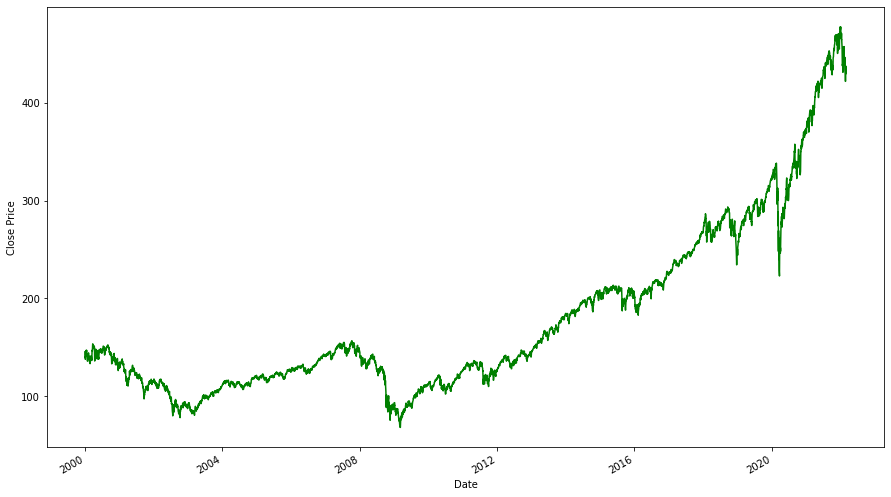

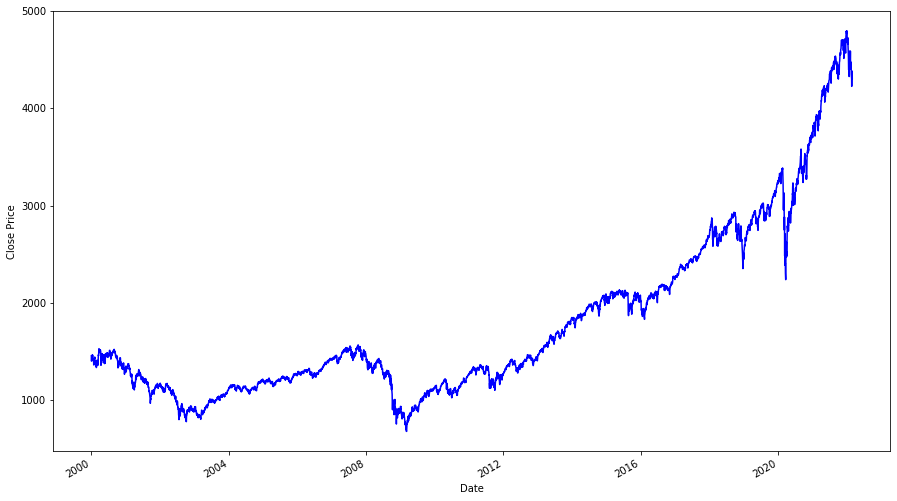

In [12]:
plt.figure(figsize = (15,9))
stocks['SPY'].Close.plot(c = 'g')
plt.ylabel('Close Price')
plt.show()

plt.figure(figsize = (15,9))
stocks['^GSPC'].Close.plot(c = 'b')
plt.ylabel('Close Price')
plt.show()

ticker_list.remove('^GSPC') # GSPC is an index and not tradeable

#### Correlation Plot
- `change` and `rsi` correlate with `return`

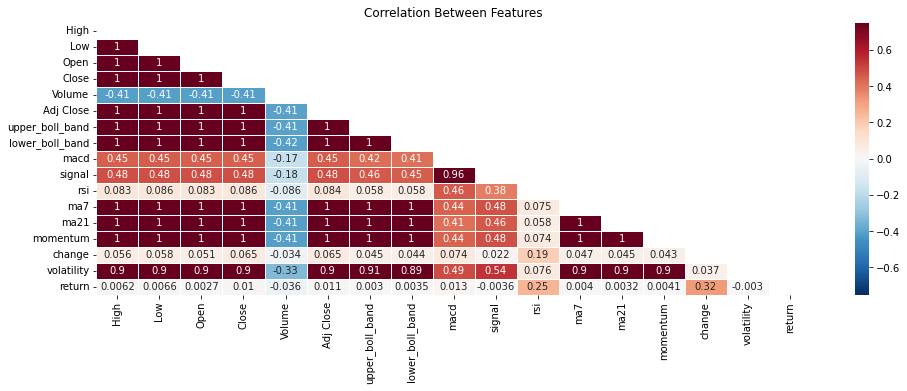

In [13]:
corr = apple_df.corr()

# Mask upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, 
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
heatmap.set_title('Correlation Between Features');

In [14]:
corr[['return']].sort_values(by='return', ascending=False)

return
return           1.000000
change           0.316699
rsi              0.253477
macd             0.013279
Adj Close        0.010615
Close            0.010190
Low              0.006577
High             0.006203
momentum         0.004107
ma7              0.004040
lower_boll_band  0.003509
ma21             0.003216
upper_boll_band  0.002954
Open             0.002743
volatility      -0.003040
signal          -0.003610
Volume          -0.035970

## $\underline{\text{Plots}}$

### MACD - Moving Average Convergence Divergence  <a id = 3.1> </a> 
[Back to Top](#0)
- Momentum indicator showing relationship between two moving averages
- Logic is that momentum has more impact on short moving average and we subtract short_ma from long_ma
- Difference is sometimes positive or negative, hence the name MACD (moving average converge/diverge oscillator)
    - Oscillator is the difference between the two MAs
    - When it is positive, we long and vice versa
- If short_ma > long_ma, then long and hold as stock is on the rise and will keep going up for some time
- If short_ma < long_ma, then clear positions

In [15]:
def macd(stock):
    plt.figure(figsize=(16,5))
    plt.plot(stock.macd, label='short_ma', color = '#b278ff')
    plt.plot(stock.signal, label='long_ma', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontsize=15)
    plt.ylabel('Strength', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(16,5))
    (stock.macd - stock.signal).plot(kind='bar',color='r')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator', fontsize=15)
    plt.show()

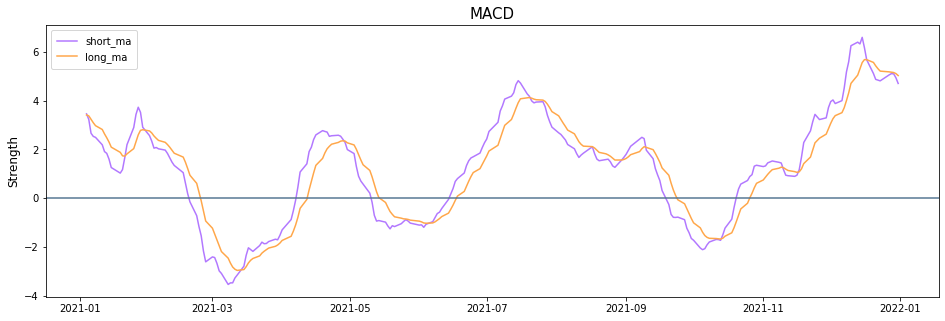

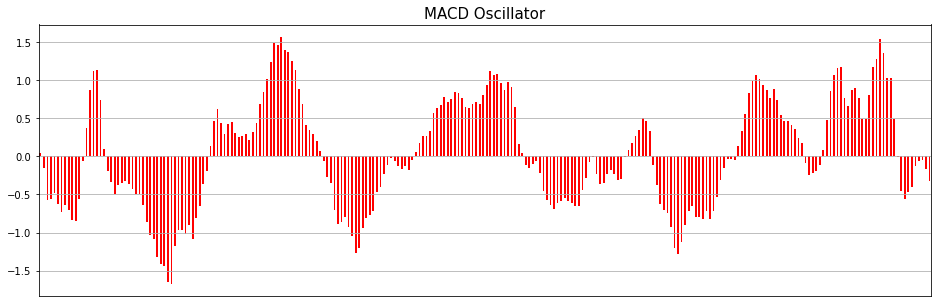

In [16]:
macd(apple_df.loc['2021':'2021'])

### Bollinger Bands  <a id = 3.2> </a> 
[Back to Top](#0)
- Price almost never leaves Bollinger Bands space
    - Price is fluctuating between three standard deviations
- Good indicator as buying/selling signal

In [17]:
def bollinger_bands_plot(stock, std=3):    
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.ma7, color='#ff6e9d', label='Moving Average (7 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label=f'Bollinger Band ({std} STD)')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Bollinger Bands', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()

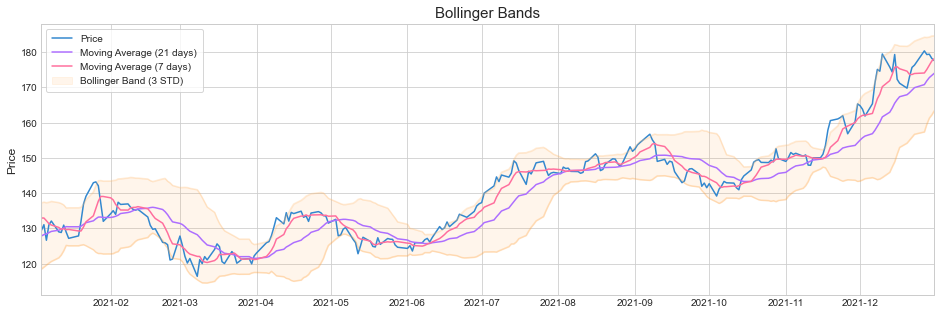

In [18]:
bollinger_bands_plot(apple_df.loc['2021':'2021'])

### RSI - Relative Strength Index <a id = 3.3> </a> 
[Back to Top](#0)
- A momentum indicator that can tell if stock is overbought or oversold
- Ranges from 0 to 100
- When index approaches 30, signal to buy
- When index approaches 70, signal to sell

In [19]:
def rsi(stock):
    plt.figure(figsize=(16,5)) 
    plt.plot(stock.index, stock.rsi, color='#ad6eff')
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.axhline(30, color='#f9989c')
    plt.axhline(70, color='#60e8ad')
    plt.title('RSI', fontsize=15)
    plt.ylabel('%', fontsize=12)
    plt.ylim([0, 100])
    plt.show()

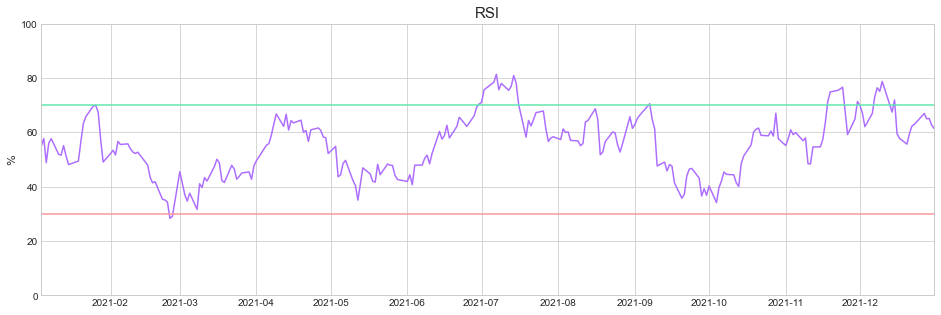

In [20]:
rsi(apple_df.loc['2021':'2021'])

### Normal Distribution <a id = 3.4> </a> 
[Back to Top](#0)
- ML algorithms require normal distribution of data to work well
- Target var `return` mostly normal

In [21]:
apple_df.head()

High       Low      Open     Close       Volume  Adj Close  \
Date                                                                         
2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855796   
2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644   
2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111   
2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304   
2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708   

            upper_boll_band  lower_boll_band      macd    signal  rsi  ma7  \
Date                                                                         
2000-01-03              NaN              NaN  0.000000  0.000000  NaN  NaN   
2000-01-04              NaN              NaN -0.006722 -0.001344  NaN  NaN   
2000-01-05              NaN              NaN -0.010843 -0.003244  NaN  NaN   
2000-01-06              NaN              NaN -0.020359 -0.006667  NaN  NaN   
2000-01-07              NaN              NaN -0.024377 -0.010209  NaN  NaN   

            ma21  momentum    change  volatility  return  
Date                                                      
2000-01-03   NaN       NaN  0.000000         NaN  0.0673  
2000-01-04   NaN       NaN -0.084263    0.059583 -0.0531  
2000-01-05   NaN       NaN  0.013392    0.044683  0.0024  
2000-01-06   NaN -2.000558 -0.080357    0.061924 -0.1048  
2000-01-07   NaN -2.084821  0.040179    0.055008  0.0311

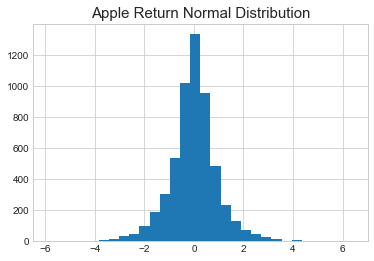

In [22]:
z = lambda x: (x - x.mean()) / x.std()

plt.hist(z(apple_df['return']), bins=30)
plt.title('Apple Return Normal Distribution', fontsize=15)
plt.show()

<Figure size 1152x360 with 0 Axes>

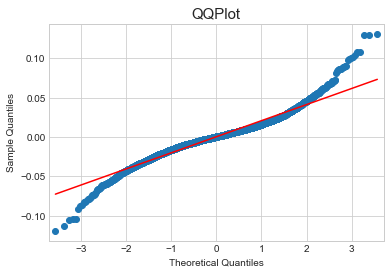

In [23]:
plt.figure(figsize=(16,5))
sm.qqplot(apple_df['return'], line='s', scale=1)
plt.title('QQPlot', fontsize=15);

## Model <a id = 4> </a> 
[Back to Top](#0)
- **Base Model:** Buy and Hold
- **Technical Indicator:** Bollinger Bands and MACD
- **NN Model:** LSTM
- **Deep Reinforcement Learning (DRL):** Evolution Strategy

### Base Model <a id = 4.0> </a> 

In [24]:
initial_cap = 10000

class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        # set the starting cash
        self.val_start = self.broker.get_cash() 
    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        globals()[f'base_ROI_{ticker_name}'] = round(self.roi*100,2)
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))
        
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    data = bt.feeds.PandasData(dataname=yf.download(ticker_name, start=start, end=end, auto_adjust=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold_Buy, "HODL")
    cerebro.broker.setcash(initial_cap)
    cerebro.run()


MSFT
[*********************100%***********************]  1 of 1 completed
ROI: 54.76, Cash: 15476.29

XOM
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

CVX
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

TSLA
[*********************100%***********************]  1 of 1 completed
ROI: 61.90, Cash: 16189.56

SPY
[*********************100%***********************]  1 of 1 completed
ROI: 30.90, Cash: 13090.21

AAPL
[*********************100%***********************]  1 of 1 completed
ROI: 41.46, Cash: 14145.77


### Technical Indicator - Bollinger Bands <a id = 4.1> </a> 
[Back to Top](#0)

In [25]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Trading History', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()


MSFT
Number of Trades: 24
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $710.08 | 7.1%


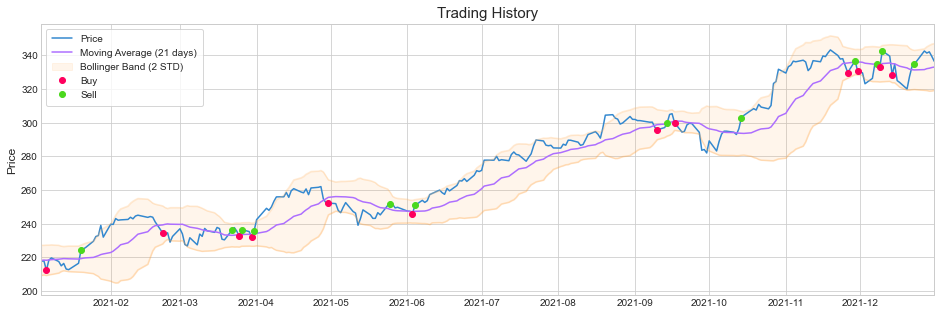


XOM
Number of Trades: 17
Time Frame: 261 days
Initial Capital: $10000
Percentage Gain: $-91.23 | -0.91%


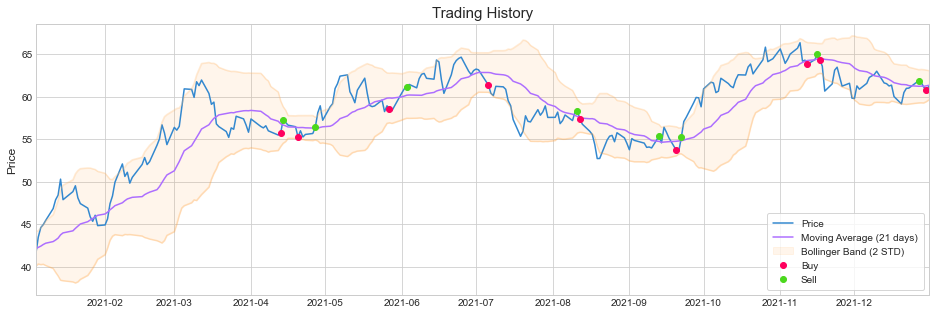


CVX
Number of Trades: 24
Time Frame: 327 days
Initial Capital: $10000
Percentage Gain: $2077.52 | 20.78%


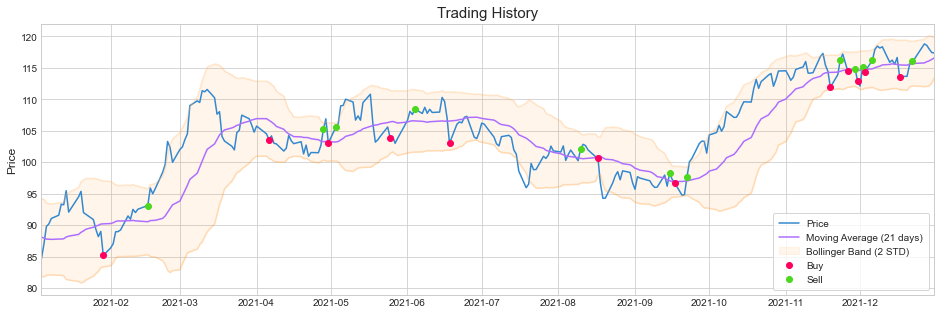


TSLA
Number of Trades: 7
Time Frame: 302 days
Initial Capital: $10000
Percentage Gain: $-2973.40 | -29.73%


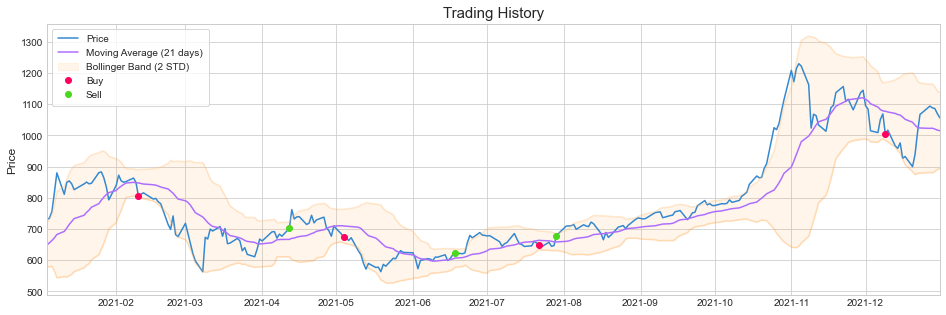


SPY
Number of Trades: 30
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $-1201.86 | -12.02%


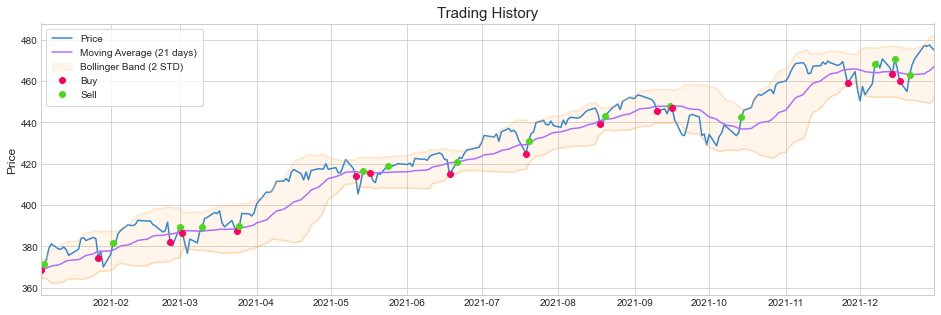


AAPL
Number of Trades: 14
Time Frame: 301 days
Initial Capital: $10000
Percentage Gain: $-850.61 | -8.51%


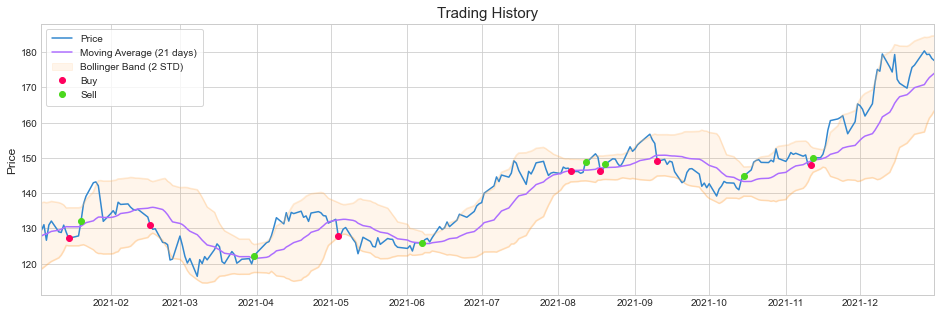

In [26]:
def bb_trading(stock, budget=10000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.ma21) and (abs(1 - today.Close / today.lower_boll_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.ma21) and (abs(1 - today.upper_boll_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Percentage Gain: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget

for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = bb_trading(stocks[ticker_name].loc['2021':'2021'], u=0.03, l=0.03);
    globals()[f'bb_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### Technical Indicator - MACD <a id = 4.2> </a> 
[Back to Top](#0)


MSFT
Number of Trades: 21
Time Frame: 340 days
Initial Capital: $10000
Profit: $1300.85 | 13.01%


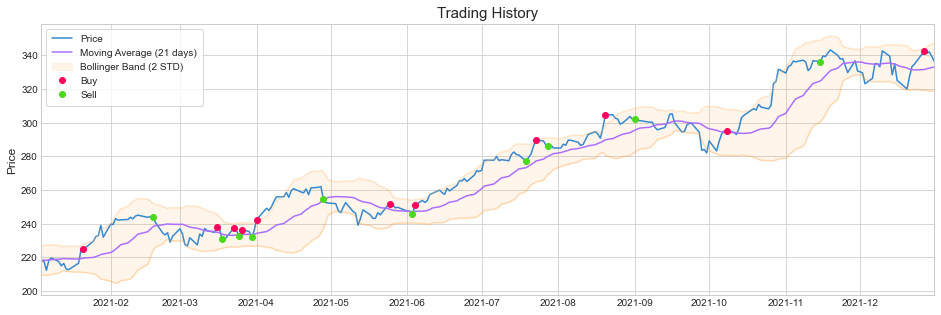


XOM
Number of Trades: 17
Time Frame: 354 days
Initial Capital: $10000
Profit: $2192.33 | 21.92%


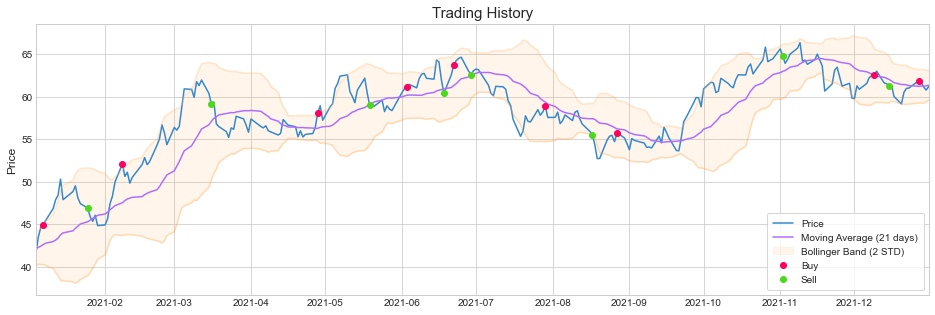


CVX
Number of Trades: 19
Time Frame: 355 days
Initial Capital: $10000
Profit: $1026.08 | 10.26%


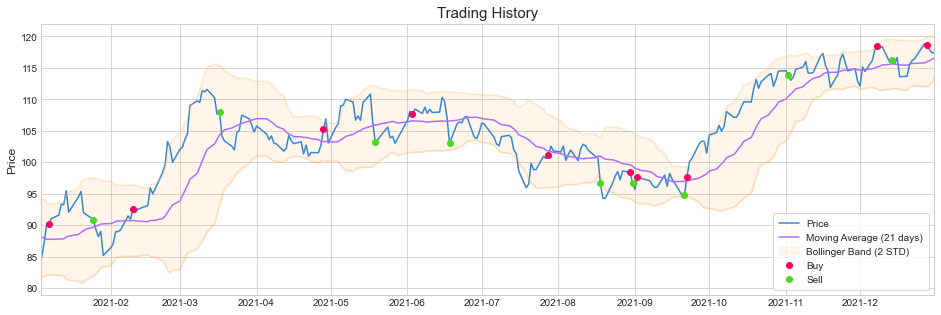


TSLA
Number of Trades: 19
Time Frame: 290 days
Initial Capital: $10000
Profit: $-3436.36 | -34.36%


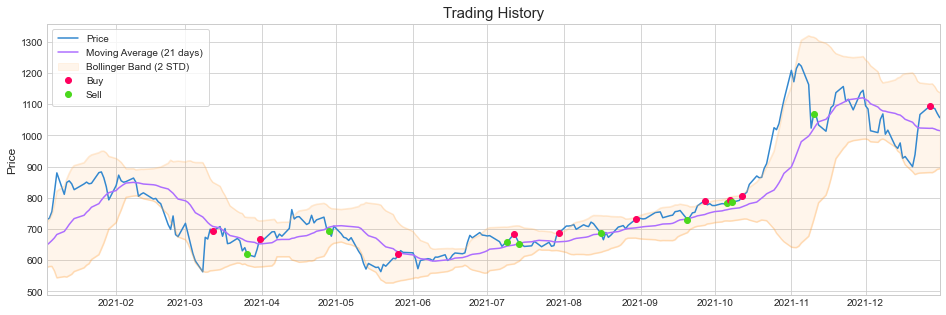


SPY
Number of Trades: 29
Time Frame: 350 days
Initial Capital: $10000
Profit: $-3882.20 | -38.82%


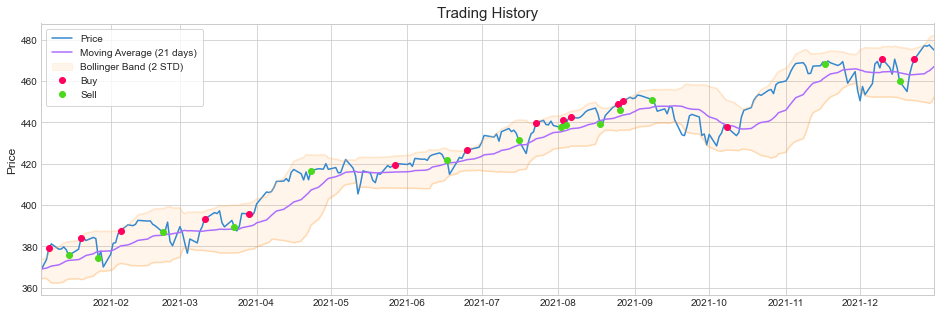


AAPL
Number of Trades: 12
Time Frame: 329 days
Initial Capital: $10000
Profit: $2835.50 | 28.35%


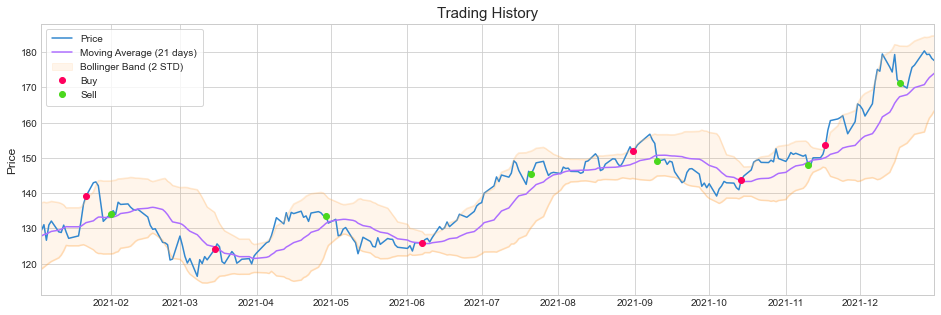

In [27]:
def macd_trading(stock, budget=10000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].macd, stock.loc[0].signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.macd, today.signal)

        if state != prev_state:

            # BUY
            if (today.macd > today.signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.macd < today.signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget


for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = macd_trading(stocks[ticker_name].loc['2021':'2021']);
    globals()[f'macd_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### LSTM <a id = 4.3> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 67ms/step - loss: 0.0417
Epoch 2/5
21/21 [==============================] - 1s 65ms/step - loss: 0.0095
Epoch 3/5
21/21 [==============================] - 1s 65ms/step - loss: 0.0055
Epoch 4/5
21/21 [==============================] - 2s 81ms/step - loss: 0.0049
Epoch 5/5
21/21 [==============================] - 2s 78ms/step - loss: 0.0049


RMSE: 10.939181187892979


Initial Capital: $10000
Final Balance: $13122.99
Percentage Gain: 31.23%


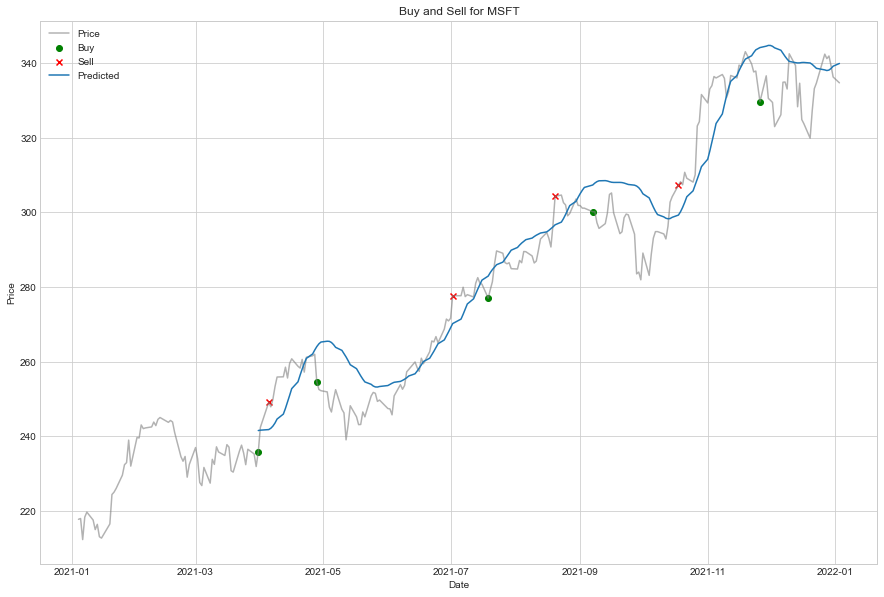


XOM
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 7s 98ms/step - loss: 0.0525
Epoch 2/5
21/21 [==============================] - 3s 149ms/step - loss: 0.0122
Epoch 3/5
21/21 [==============================] - 1s 65ms/step - loss: 0.0103
Epoch 4/5
21/21 [==============================] - 2s 70ms/step - loss: 0.0077
Epoch 5/5
21/21 [==============================] - 2s 77ms/step - loss: 0.0115


RMSE: 1.6650160621352483


Initial Capital: $10000
Final Balance: $12314.37
Percentage Gain: 23.14%


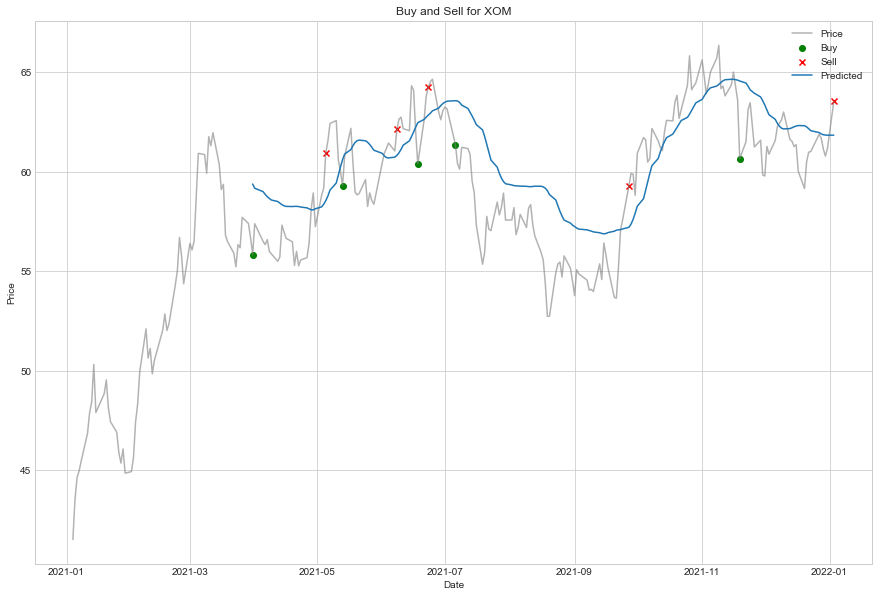


CVX
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 9s 127ms/step - loss: 0.0569
Epoch 2/5
21/21 [==============================] - 2s 84ms/step - loss: 0.0154
Epoch 3/5
21/21 [==============================] - 3s 131ms/step - loss: 0.0112
Epoch 4/5
21/21 [==============================] - 3s 151ms/step - loss: 0.0094
Epoch 5/5
21/21 [==============================] - 3s 140ms/step - loss: 0.0074


RMSE: 4.652268957574871


Initial Capital: $10000
Final Balance: $10472.64
Percentage Gain: 4.73%


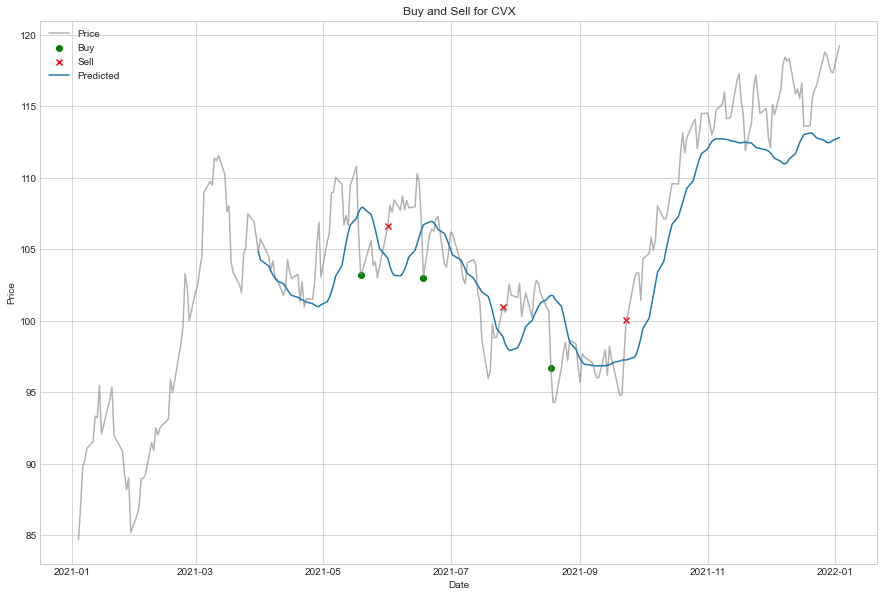


TSLA
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 7s 71ms/step - loss: 0.0391
Epoch 2/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0112
Epoch 3/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0098
Epoch 4/5
21/21 [==============================] - 4s 196ms/step - loss: 0.0103
Epoch 5/5
21/21 [==============================] - 3s 122ms/step - loss: 0.0089


RMSE: 91.81466218989115


Initial Capital: $10000
Final Balance: $13895.18
Percentage Gain: 38.95%


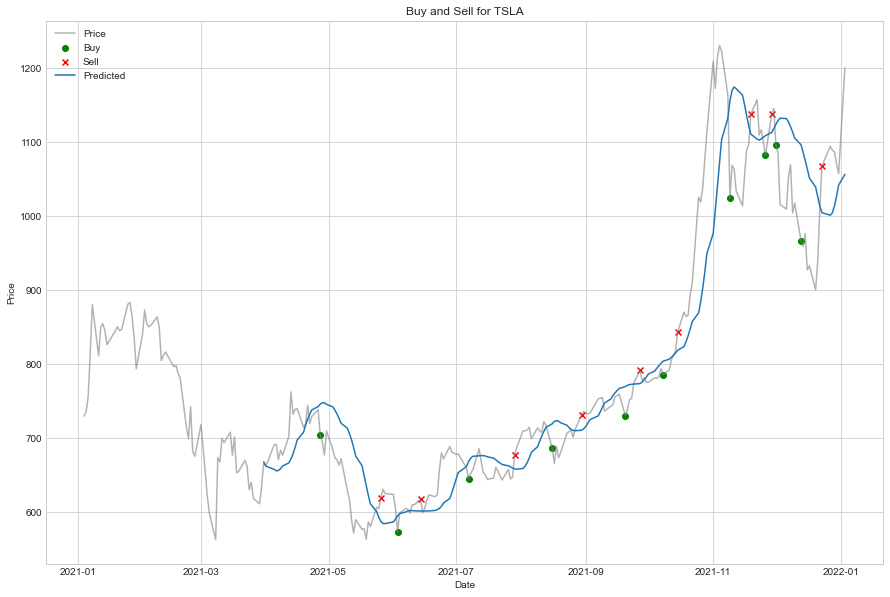


SPY
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 11s 82ms/step - loss: 0.0462
Epoch 2/5
21/21 [==============================] - 2s 88ms/step - loss: 0.0067
Epoch 3/5
21/21 [==============================] - 2s 81ms/step - loss: 0.0073
Epoch 4/5
21/21 [==============================] - 2s 74ms/step - loss: 0.0050
Epoch 5/5
21/21 [==============================] - 2s 73ms/step - loss: 0.0049


RMSE: 9.489733363532382


Initial Capital: $10000
Final Balance: $11488.48
Percentage Gain: 14.88%


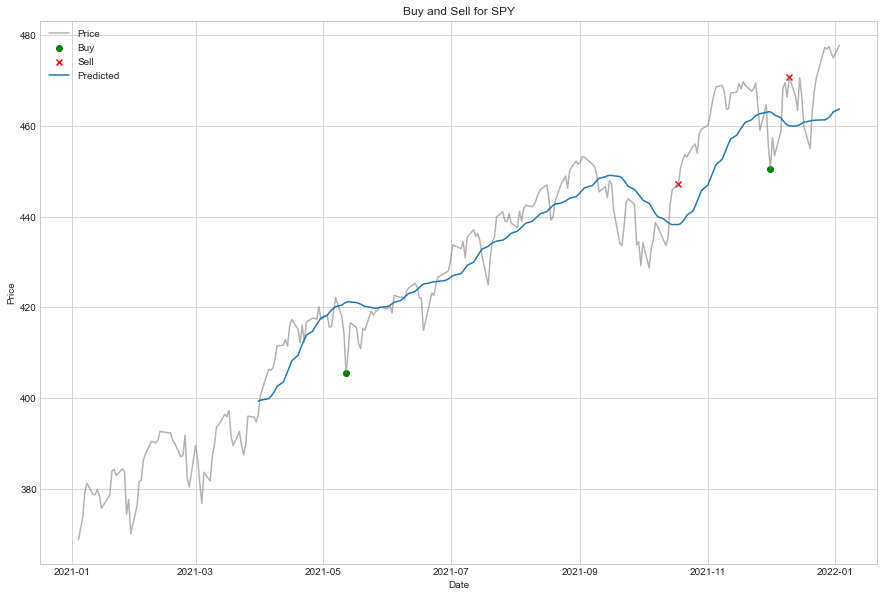


AAPL
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 8s 76ms/step - loss: 0.0197
Epoch 2/5
21/21 [==============================] - 2s 76ms/step - loss: 0.0069
Epoch 3/5
21/21 [==============================] - 2s 74ms/step - loss: 0.0057
Epoch 4/5
21/21 [==============================] - 2s 74ms/step - loss: 0.0051
Epoch 5/5
21/21 [==============================] - 2s 74ms/step - loss: 0.0050


RMSE: 7.799424387606979


Initial Capital: $10000
Final Balance: $11586.18
Percentage Gain: 15.86%


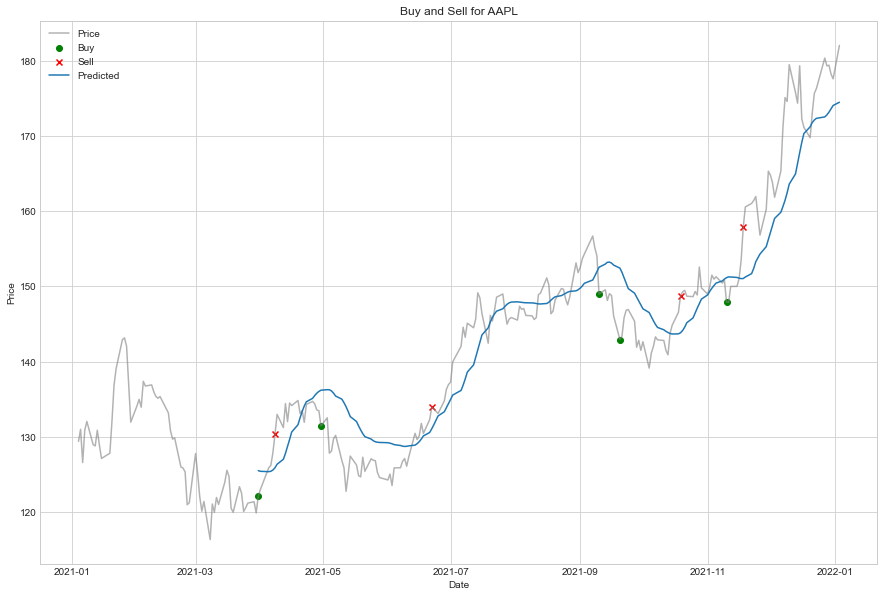

In [28]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_lstm.ipynb
    globals()[f'lstm_ROI_{ticker_name}'] = round(100*(agent.total_balance()-invest)/invest, 2)

### DRL - Evolution Strategy <a id = 4.4> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 3.524799
iter 20. reward: 4.274799
iter 30. reward: 7.498299
iter 40. reward: 9.306398
iter 50. reward: 8.525698
iter 60. reward: 5.155799
iter 70. reward: 10.585199
iter 80. reward: 2.859998
iter 90. reward: 14.333799
iter 100. reward: 14.265299
iter 110. reward: 7.992399
iter 120. reward: 11.384099
iter 130. reward: 15.874398
iter 140. reward: 10.884399
iter 150. reward: 13.080899
iter 160. reward: 12.926699
iter 170. reward: 11.466899
iter 180. reward: 15.933799
iter 190. reward: 15.952699
iter 200. reward: 15.544600
iter 210. reward: 16.752100
iter 220. reward: 13.676599
iter 230. reward: 14.497498
iter 240. reward: 11.560999
iter 250. reward: 17.139199
iter 260. reward: 13.433599
iter 270. reward: 18.202700
iter 280. reward: 17.783000
iter 290. reward: 9.209700
iter 300. reward: 20.522800
iter 310. reward: 21.447800
iter 320. reward: 21.428201
iter 330. reward: 20.955000
iter 340. reward: 2

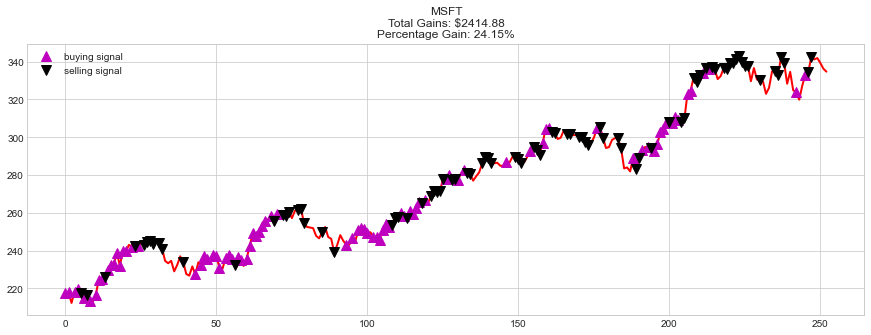


XOM
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.408600
iter 20. reward: 1.977700
iter 30. reward: 2.103500
iter 40. reward: 2.078200
iter 50. reward: 2.382800
iter 60. reward: 2.313500
iter 70. reward: 2.652800
iter 80. reward: 2.299000
iter 90. reward: 2.448400
iter 100. reward: 2.270100
iter 110. reward: 2.790400
iter 120. reward: 2.798300
iter 130. reward: 2.950200
iter 140. reward: 2.884700
iter 150. reward: 3.268800
iter 160. reward: 3.463200
iter 170. reward: 3.521200
iter 180. reward: 3.422200
iter 190. reward: 3.387500
iter 200. reward: 2.981300
iter 210. reward: 3.022200
iter 220. reward: 3.343000
iter 230. reward: 3.354200
iter 240. reward: 3.370200
iter 250. reward: 3.516400
iter 260. reward: 3.536900
iter 270. reward: 3.665800
iter 280. reward: 3.560200
iter 290. reward: 3.689400
iter 300. reward: 3.738700
iter 310. reward: 3.407300
iter 320. reward: 3.565000
iter 330. reward: 3.199400
iter 340. reward: 3.777300
iter 350. reward:

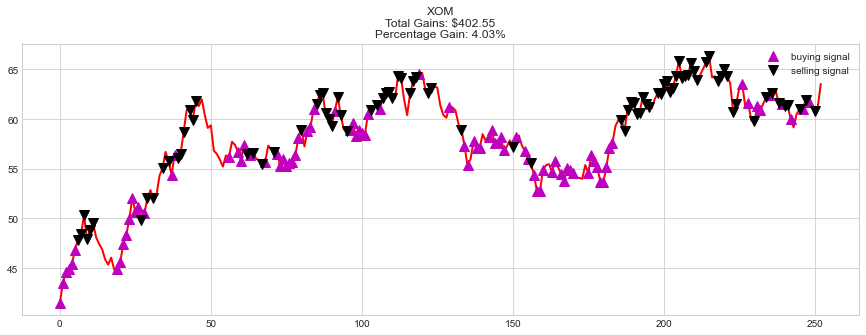


CVX
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.756100
iter 20. reward: 2.445300
iter 30. reward: 2.659100
iter 40. reward: 3.991000
iter 50. reward: 3.853600
iter 60. reward: 4.010000
iter 70. reward: 3.815400
iter 80. reward: 3.766600
iter 90. reward: 3.965600
iter 100. reward: 4.496000
iter 110. reward: 4.412800
iter 120. reward: 5.028400
iter 130. reward: 5.455700
iter 140. reward: 4.633200
iter 150. reward: 5.473000
iter 160. reward: 5.553000
iter 170. reward: 6.225400
iter 180. reward: 6.750200
iter 190. reward: 6.471200
iter 200. reward: 6.754700
iter 210. reward: 6.254900
iter 220. reward: 5.416100
iter 230. reward: 6.418200
iter 240. reward: 6.822100
iter 250. reward: 6.649500
iter 260. reward: 6.052400
iter 270. reward: 3.752700
iter 280. reward: 6.434000
iter 290. reward: 6.721500
iter 300. reward: 6.184300
iter 310. reward: 6.704800
iter 320. reward: 6.594800
iter 330. reward: 7.001700
iter 340. reward: 7.101100
iter 350. reward:

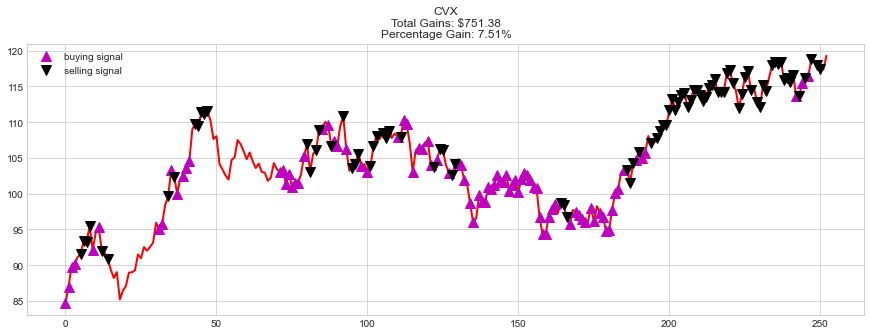


TSLA
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 21.888602
iter 20. reward: 42.551402
iter 30. reward: 43.568701
iter 40. reward: 48.423801
iter 50. reward: 53.294702
iter 60. reward: 55.894299
iter 70. reward: 53.211600
iter 80. reward: 53.566300
iter 90. reward: 56.626100
iter 100. reward: 61.509101
iter 110. reward: 65.301700
iter 120. reward: 64.772000
iter 130. reward: 65.884500
iter 140. reward: 69.999798
iter 150. reward: 70.193698
iter 160. reward: 69.731100
iter 170. reward: 71.482800
iter 180. reward: 71.585098
iter 190. reward: 70.111799
iter 200. reward: 72.453999
iter 210. reward: 69.269598
iter 220. reward: 73.450798
iter 230. reward: 76.294297
iter 240. reward: 78.348599
iter 250. reward: 79.294598
iter 260. reward: 79.221599
iter 270. reward: 79.284598
iter 280. reward: 83.773199
iter 290. reward: 84.540599
iter 300. reward: 85.063998
iter 310. reward: 83.649299
iter 320. reward: 89.869797
iter 330. reward: 94.872299
iter 340. 

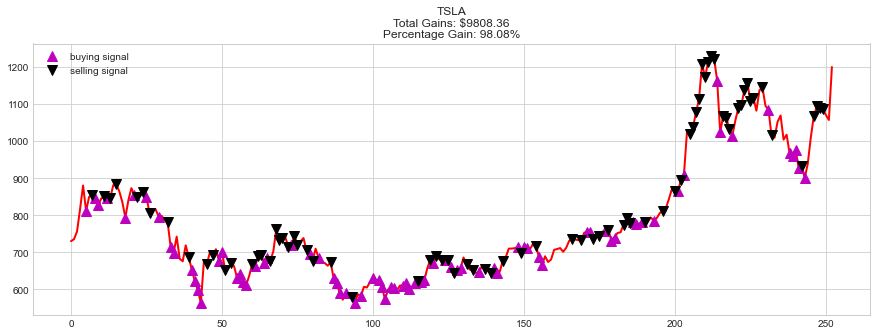


SPY
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.711700
iter 20. reward: 3.780000
iter 30. reward: 4.789599
iter 40. reward: 5.321299
iter 50. reward: 5.952999
iter 60. reward: 6.940299
iter 70. reward: 5.597799
iter 80. reward: 7.285099
iter 90. reward: 5.794500
iter 100. reward: 7.923200
iter 110. reward: 8.905900
iter 120. reward: 9.944800
iter 130. reward: 8.829399
iter 140. reward: 8.115800
iter 150. reward: 11.715100
iter 160. reward: 12.012101
iter 170. reward: 12.154200
iter 180. reward: 10.855500
iter 190. reward: 11.517700
iter 200. reward: 13.438400
iter 210. reward: 14.353800
iter 220. reward: 13.399900
iter 230. reward: 12.326001
iter 240. reward: 13.381500
iter 250. reward: 12.902600
iter 260. reward: 13.330301
iter 270. reward: 12.951400
iter 280. reward: 14.249900
iter 290. reward: 14.239099
iter 300. reward: 15.064900
iter 310. reward: 15.853300
iter 320. reward: 15.492100
iter 330. reward: 16.288600
iter 340. reward: 16.4686

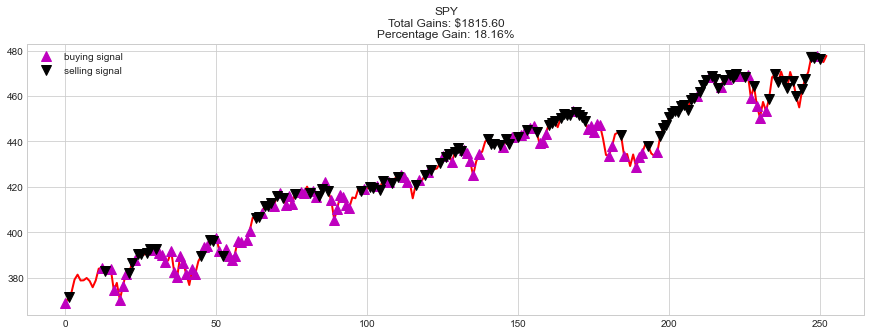


AAPL
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 2.275999
iter 20. reward: 5.124100
iter 30. reward: 6.457700
iter 40. reward: 7.315900
iter 50. reward: 8.042999
iter 60. reward: 8.634300
iter 70. reward: 9.350000
iter 80. reward: 10.502000
iter 90. reward: 9.940100
iter 100. reward: 8.463500
iter 110. reward: 13.599500
iter 120. reward: 14.187400
iter 130. reward: 13.410900
iter 140. reward: 13.098200
iter 150. reward: 16.046200
iter 160. reward: 12.980200
iter 170. reward: 12.014700
iter 180. reward: 12.902600
iter 190. reward: 14.730800
iter 200. reward: 13.543300
iter 210. reward: 13.201400
iter 220. reward: 13.396500
iter 230. reward: 14.314500
iter 240. reward: 14.024901
iter 250. reward: 14.903800
iter 260. reward: 11.229600
iter 270. reward: 15.662800
iter 280. reward: 14.609601
iter 290. reward: 15.504800
iter 300. reward: 15.188900
iter 310. reward: 16.216100
iter 320. reward: 16.165400
iter 330. reward: 16.422800
iter 340. reward: 1

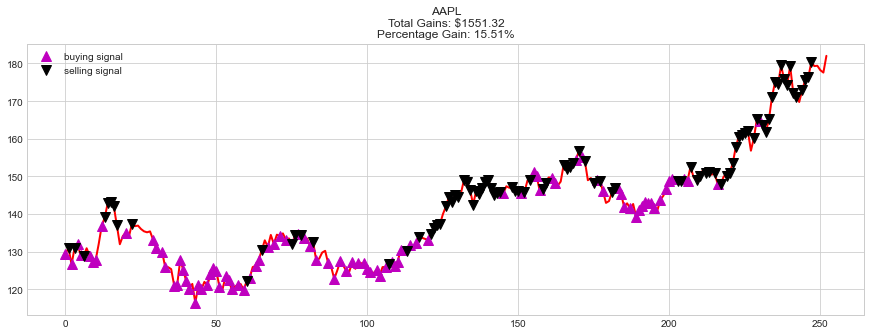

In [29]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_es.ipynb
    globals()[f'es_ROI_{ticker_name}'] = round(invest, 2)

## Results <a id = 5> </a> 
[Back to Top](#0)

In [30]:
algo_list = ['base_ROI_', 'bb_ROI_', 'macd_ROI_', 'lstm_ROI_', 'es_ROI_']
gen_list = []

for a in algo_list:
    for t in ticker_list:
        gen_list.append(a+t)

models_list = ['Base Model', 'Bollinger Bands', 'MACD', 'LSTM', 'Evolution Strategy']

def average(y):
    return str(round(sum([float(x.split(' ')[0]) for x in y])/len(y),1))+' %'

base = [f'{eval(x):.1f} %' for x in gen_list if algo_list[0] in x]
base_ave = average(base)

bb = [f'{eval(x):.1f} %' for x in gen_list if algo_list[1] in x]
bb_ave = average(bb)

macd = [f'{eval(x):.1f} %' for x in gen_list if algo_list[2] in x]
macd_ave = average(macd)

lstm = [f'{eval(x):.1f} %' for x in gen_list if algo_list[3] in x]
lstm_ave = average(lstm)

es = [f'{eval(x):.1f} %' for x in gen_list if algo_list[4] in x]
es_ave = average(es)

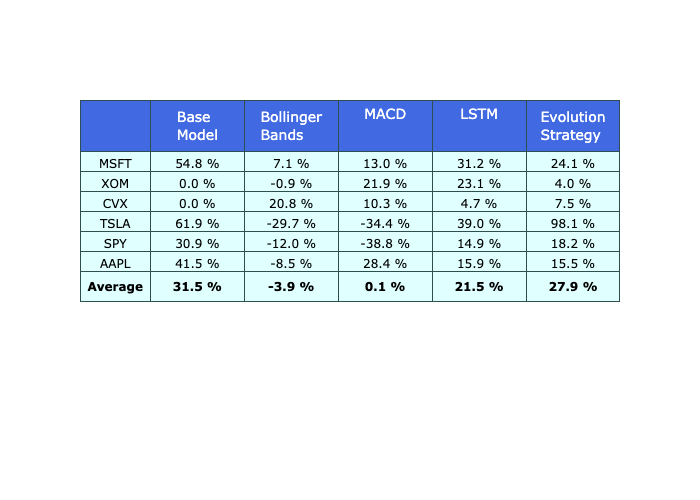

In [31]:
fig = go.Figure(data=[go.Table(
    columnwidth = [300, 400],
    header=dict(values=['']+models_list,
                line_color='darkslategray',
                fill_color='royalblue',
                align='center',
                font=dict(color='white', size=14)
               ),
    cells=dict(values=[
                 ticker_list+['<b>Average</b>'],
                 base+['<b>'+base_ave+'</b>'], 
                 bb+['<b>'+bb_ave+'</b>'],
                 macd+['<b>'+macd_ave+'</b>'],
                 lstm+['<b>'+lstm_ave+'</b>'],
                 es+['<b>'+es_ave+'</b>']
                 ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center',
               font=dict(color='black', size=12)
              )
)])
fig.show()
fig.write_image("images/result_table.png")
Image('images/result_table.png')

## Conclusion <a id = 6> </a> 
[Back to Top](#0)

- **Base model (buy and hold strategy)** on average performed the best with **average ROI of 31.5%**
- Technical indicators Bollinger Bands and MACD did very poorly
- Machine learning models fared better compared to technical indicators
- The stock market is a very volatile and complex system
- Historical data is not enough to explain its behavior


## Future Work <a id = 7> </a> 
[Back to Top](#0)

To improve our predictions, the below could be performed for future considerations:
- Continue refining the hyperparameters of current models
- Utilize other models such as ADX (Average Directional Movement Index) and other DRL models
- Fundamental analysis
- Sentiment analysis (twitter, news, social media etc.)
- Local/global economy analysis

## References <a id = 8> </a> 
[Back to Top](#0)

- Turin, A. (2020, March 8). Machine Learning for day trading. Medium. Retrieved March 2, 2022, from towardsdatascience.com/machine-learning-for-day-trading-27c08274df54.

- Jansen, Stefan. “Machine Learning for Algorithmic Trading.” GitHub, PacktPublishing, github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition.

- T.M. “Quant-Trading.” GitHub, 1 Mar. 2022, github.com/je-suis-tm/quant-trading. Accessed 2 Mar. 2022.

- Dector, Aldo. “Moving-Average-Trading-Strategy-With-Python.” GitHub, 25 Nov. 2021, github.com/aldodec/Moving-Average-Trading-Strategy-with-Python. Accessed 2 Mar. 2022.

- Zhang, Leon. “Algorithmic Stock Trading.” GitHub, 30 Jan. 2022, github.com/leonz12345/Algorithmic_Stock_Trading. Accessed 2 Mar. 2022.

- ZOLKEPLI, HUSEIN. “Huseinzol05/Stock-Prediction-Models.” GitHub, 1 Mar. 2022, github.com/huseinzol05/Stock-Prediction-Models. Accessed 2 Mar. 2022.

- Orac, Roman. “Buy and Hold Trading Strategy.” Medium, 13 Dec. 2020, towardsdatascience.com/buy-and-hold-trading-strategy-66b4c3ac9b68. Accessed 2 Mar. 2022.